In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
years = range(2000,2020,4)
df = pd.read_csv('counties.csv')

In [3]:
data = df.drop(columns=['state', 'county'])
data = data.dropna(axis=0,how='any')
data.describe()

,2000D,2000R,2000O,2004D,2004R,2004O,2008D,2008R,2008O,2012D,2012R,2012O,2016D,2016R,2016O
count,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2.875000e+03,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000,2.875000e+03,2875.000000,2875.000000
mean,1.699424e+04,16533.856000,1352.073391,1.956915e+04,2.028555e+04,508.671652,2.298134e+04,19539.632696,610.991304,2.171365e+04,19761.090783,886.516522,2.175607e+04,20524.178783,2543.772522
std,5.942532e+04,39923.542134,4232.141433,6.769202e+04,4.869764e+04,1976.171276,7.944593e+04,45955.629730,1913.652362,7.628626e+04,45649.528293,3056.034805,8.298175e+04,44262.493478,7726.198627
min,1.400000e+01,106.000000,3.000000,1.200000e+01,6.500000e+01,0.000000,8.000000e+00,67.000000,0.000000,5.000000e+00,54.000000,1.000000,4.000000e+00,58.000000,3.000000
25%,1.751500e+03,2689.000000,109.000000,1.882500e+03,3.124500e+03,43.000000,1.930500e+03,2956.000000,78.500000,1.662500e+03,3021.500000,84.000000,1.240000e+03,3346.000000,195.000000
50%,3.830000e+03,5363.000000,278.000000,4.177000e+03,6.522000e+03,98.000000,4.493000e+03,6297.000000,182.000000,4.014000e+03,6398.000000,195.000000,3.199000e+03,7194.000000,529.000000
75%,9.580500e+03,13166.000000,886.500000,1.078350e+04,1.646800e+04,302.000000,1.262450e+04,16042.000000,453.500000,1.147700e+04,16391.500000,564.000000,9.940500e+03,17945.500000,1736.500000
max,1.710505e+06,871930.000000,112719.000000,1.907736e+06,1.076225e+06,39515.000000,2.295853e+06,956425.000000,65970.000000,2.216903e+06,885333.000000,78831.000000,2.464364e+06,769743.000000,200201.000000


In [4]:
data = data.to_numpy(dtype=np.int64)


In [5]:
def plotCounty(state,county,dem,gop,other,predicted=None):
    if predicted is None:
        years = range(2000,2020,4)
        plt.figure()
        plt.plot(years,dem,'b',label='Democrat')
        plt.plot(years,gop,'r',label='Republican')
        plt.plot(years,other,'y',label='Other')
        plt.plot(years,dem+gop+other,'k',label='Total')
    else:
        years = range(2000,2024,4)
        plt.figure()
        d = np.append(dem,predicted[0]*20000)
        r = np.append(gop,predicted[1]*20000)
        o = np.append(other,predicted[2]*250)
        plt.plot(years,d,'b',label='Democrat')
        plt.plot(years,r,'r',label='Republican')
        plt.plot(years,o,'y',label='Other')
        plt.plot(years,d+r+o,'k',label='Total')
    plt.xlabel('Year')
    plt.ylabel('Votes')
    plt.title(county+', '+state)
    plt.xticks(years)
    plt.legend()
    plt.show()

In [6]:
def convertbyParty(point):
    d = point[:,::3]/20000
    r = point[:,1::3]/20000
    o = point[:,2::3]/250
    return d,r,o
print(df.loc[0])
convertbyParty(np.expand_dims(df.loc[0].values[2:],0))

state          AL
county    Autauga
2000D        4942
2000R       11993
2000O         273
2004D        4758
2004R       15196
2004O         127
2008D        6093
2008R       17403
2008O         145
2012D        6363
2012R       17379
2012O         190
2016D        5936
2016R       18172
2016O         865
Name: 0, dtype: object


(array([[0.2471, 0.2379, 0.30465, 0.31815, 0.2968]], dtype=object),
 array([[0.59965, 0.7598, 0.87015, 0.86895, 0.9086]], dtype=object),
 array([[1.092, 0.508, 0.58, 0.76, 3.46]], dtype=object))

In [7]:
def getDataset(data,batch_size,split=True):
    data = np.expand_dims(data,axis=-1)
    if split:
        np.random.shuffle(data)
    num = data.shape[0]
    train_data = data[:int(num*0.6)]
    val_data = data[int(num*0.6):int(num*0.8)]
    test_data = data[int(num*0.8):]
    def createDS(point,label=True):
        d,r,o=convertbyParty(point)

        if label:
            new_data = np.vstack((d,r))
            new_data = np.vstack((new_data,new_data*1.5,new_data*2))
        else:
            new_data = np.vstack((d,r,o))
        ds = tf.data.Dataset.from_tensor_slices(new_data)
        if label:
            ds = ds.map(lambda p: (p[:-1],p[-1]))
        else:
            ds = ds.map(lambda p: p[1:])
        return ds.batch(batch_size).prefetch(1) if label else ds
    if split:
        return createDS(train_data),createDS(val_data),createDS(test_data)
    else:
        return createDS(data,False).batch(100000)

In [8]:
train_ds, val_ds, test_ds = getDataset(data,8)
# list(getDataset(data,1,False))[:3]
train_ds


<PrefetchDataset shapes: ((None, 4, 1), (None, 1)), types: (tf.float64, tf.float64)>

In [9]:
# model = tf.keras.Sequential([
#     tf.keras.layers.Conv1D(2,2,activation='relu',input_shape=(4,1)),
#     tf.keras.layers.Conv1D(2,2,activation='relu'),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(4,activation='relu'),
#     tf.keras.layers.Reshape((4,1)),
#     tf.keras.layers.LSTM(8,return_sequences=True),
#     tf.keras.layers.LSTM(8,return_sequences=True),
#     tf.keras.layers.LSTM(8,return_sequences=True),
# ])

In [9]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(40,2,activation='relu',input_shape=(4,1)),
    tf.keras.layers.GRU(80,return_sequences=True),
    tf.keras.layers.GRU(80),
    tf.keras.layers.Dense(1)
])

In [10]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-6 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.Adam(lr=1e-6)
model.compile(loss='mae',optimizer=optimizer,metrics=['mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 3, 40)             120       
_________________________________________________________________
gru (GRU)                    (None, 3, 80)             29280     
_________________________________________________________________
gru_1 (GRU)                  (None, 80)                38880     
_________________________________________________________________
dense (Dense)                (None, 1)                 81        
Total params: 68,361
Trainable params: 68,361
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_checkpoint = tf.keras.callbacks.ModelCheckpoint("model.h5", save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(patience=50)


In [13]:
model.fit(train_ds,epochs=1000,validation_data=val_ds,callbacks=[model_checkpoint,early_stopping])

In [14]:
c = 'Racine'
s = 'WI'
r = df[(df['state']==s)&(df['county']==c)]

In [19]:
model4 = tf.keras.models.load_model('model.h5')
row = r.drop(columns=['state','county'])
row = row.to_numpy()
dataset = getDataset(row,8,False)
model4.evaluate(train_ds)
model4.evaluate(val_ds)
model4.evaluate(test_ds)

432/432 [==============================] - 1s 2ms/step - loss: 0.1481 - mean_squared_error: 0.1201

[0.14812326431274414, 0.12013345211744308]

In [16]:
results = model4.predict(dataset)
results

array([[  2.1110964],
       [  2.2451189],
       [-25.416403 ]], dtype=float32)

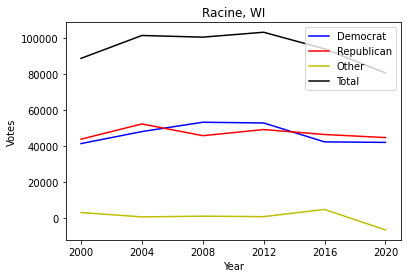

In [17]:
dem = np.array(r.values.tolist()[0][2::3])
gop = np.array(r.values.tolist()[0][3::3])
other = np.array(r.values.tolist()[0][4::3])
plotCounty(s,c,dem,gop,other,results)